<a href="https://colab.research.google.com/github/Jorbnc/MAIA-DL/blob/master/Mini_Proyecto_1_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

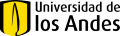

<span style="font-family:Cambria Math">
    
# Mini Proyecto 1, Técnica de *Deep Learning*: Clasificación de MRI con Redes Neuronales Convolucionales para Tipos de Cáncer

## Descripción del problema:

La **resonancia magnética** (MRI) es clave para detectar y clasificar tumores cerebrales. Gracias a las redes neuronales convolucionales (CNN), hoy podemos analizar estas imágenes con gran precisión, ya que las CNN aprenden a reconocer los patrones propios de cada tipo de tumor.

Un estudio completo de MRI genera un volumen 3D formado por muchas **capas bidimensionales**. Procesar el volumen entero resulta costoso en tiempo y recursos.

Para este proyecto abordaremos el problema de forma más ligera: trabajaremos solo con las imágenes 2D extraídas de cada capa. Así reducimos la carga computacional y convertimos la tarea en una clasificación de imágenes individuales, sin perder la información esencial para el diagnóstico.

## Objetivo:

Desarrollar un método basado en redes neuronales convolucionales que permita
clasificar con exactitud imágenes extraídas de MRIs en una de las 4 categorías.

- **Glioma**: Detecta masas anómalas con bordes irregulares y heterogeneidad en
el tejido cerebral.
- **Meningioma**: Identifica tumores bien delimitados originados en las meninges.
- **Pituitary**: Clasifica adenomas hipofisarios en la región selar.
- **Tejido sano**: Diferencia el tejido cerebral normal sin anomalías presentes
*****
</span>

***

<div class="alert alert-block alert-info">
<bNotar:</b >

**Este proyecto es realizado por Andrés Felipe Ñungo y Jordan Bryan Núñez Campos para entrega el 2 de mayo.**

Tareas:

* Ajustar el código para tomar un solo canal (Andrés Ñungo)
* Tomar los papers investigar en la teoría como se debería ver un cerebro enfermo (Andrés Ñungo)
* Mejorar la explicación del código

</div24></span>

<span style="font-family:Cambria Math">

***
    
# Índice
El *notebook* abordará el proyecto de la siguiente manera:

1. [Instalación y carga de librerías](#instalacion-y-carga-de-librerias)

2. [Análisis exploratorio y preparación de los datos](#analisis-exploratorio-y-preparacion-de-los-datos)

7. [Referencias](#referencias)
</span>

***

<span style="font-family:Cambria Math">

# 1. Instalación y cargue de librerías
</span>

<span style="font-family:Cambria Math">

Empezamos por el cargue de las librerias que se usarán, para efectos de este proyecto. De acuerdo, a la sugerencia del enunciado del proyecto se trabaja con **`pytorch`** ya que es unos de las librerías más conocidas e intuitivas para trabajar el problema de clasificación con redes neuronales convolucionales[¹].

También importamos el módulo central **`PIL`** (Python Imaging Library), *Image* que nos va a permitir más adelante el cargue, guardado y transformación de las imágenes a trabajar.

Adicionalmente nos aseguramos de ignorar alertamientos y de identificar las versiones de las librerías usadas para que el ejercicio pueda ser replicable más adelante.
</span>

In [1]:
# Librerías básicas
import os
from PIL import Image
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Obtención de la información
import kagglehub

# Modelado
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split, DataLoader

# Evaluación
from sklearn.metrics import confusion_matrix, accuracy_score , precision_recall_curve, roc_auc_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Para guardar los pesos tuneados
import copy

In [2]:
#Visulización adecuada de gráficas en notebook
%matplotlib inline

In [3]:
# Ignorar las warnings
import warnings
warnings.filterwarnings("ignore")

In [8]:
from importlib.metadata import version
#Librerias usadas
librerias = ['numpy', 'scikit-learn', 'torch', 'joblib','pandas']
for library in librerias:
  print(library, ": ", version(library))

numpy :  2.0.2
scikit-learn :  1.6.1
torch :  2.6.0+cu124
joblib :  1.4.2
pandas :  2.2.2


***
<span style="font-family:Cambria Math">

# 2. Análisis exploratorio y preparación de los datos

Sugiero algunas consideraciones de temas de forma:
- Para citar dentro del notebook usar súper-índices, por ejemmplo: [¹]
- Palabras en *english* usar cursivas
- Variables o parámetros usar la siguiente notación:  **`variable`**
</span>

In [ ]:
# Descargar el conjunto de datos a partir del path suministrado
path_kaggle = kagglehub.dataset_download("rm1000/brain-tumor-mri-scans")
print("Path to dataset files:", path_kaggle)

Path to dataset files: /kaggle/input/brain-tumor-mri-scans


In [ ]:
labels = ['glioma', 'healthy', 'meningioma', 'pituitary']
num_labels = len(labels)
label2idx = {label: idx for idx, label in enumerate(labels)}
idx2label = {v: k for k, v in label2idx.items()}

# Cargar solo los paths de las imágenes
path_raiz = path_kaggle
dir_paths = {label: os.path.join(path_raiz, label) for label in labels}

# Dataframe con los paths
df_paths = []
for label, path in dir_paths.items():
    imagenes = os.listdir(path)
    for img in imagenes:
        if img.lower().endswith('.jpg'):
            img_path = os.path.join(path, img)
            df_paths.append({'img_path': img_path, 'label': label})

df_paths = pd.DataFrame(df_paths)
df_paths.head()

,img_path,label
0,/kaggle/input/brain-tumor-mri-scans/glioma/066...,glioma
1,/kaggle/input/brain-tumor-mri-scans/glioma/126...,glioma
2,/kaggle/input/brain-tumor-mri-scans/glioma/073...,glioma
3,/kaggle/input/brain-tumor-mri-scans/glioma/010...,glioma
4,/kaggle/input/brain-tumor-mri-scans/glioma/037...,glioma


***
<span style="font-family:Cambria Math">

XXXXXXX
</span>

***
<span style="font-family:Cambria Math">

# 3. Definición de *pipelines* de preprocesamiento

</span>

***
<span style="font-family:Cambria Math">

## Análisis de la Distribución de los Datos


</span>

***

<span style="font-family:Cambria Math">

## Pipeline de Preprocesamiento

`CenterCrop` (en lugar de `RandomCrop`) funciona bien porque los imágenes original prese

</span>

In [ ]:
# Pipeline de preprocesamiento recomendado en https://pytorch.org/hub/pytorch_vision_alexnet/
transform_pipeline = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# COMPROBAR:
# Al parecer este tipo de lógica se llama "Lazy Evaluation/Programming"
# Es decir, solo se declara lo que se queire hacer, pero se pospone la ejecución para cuando sea realmente necesario

# Subclase de Dataset de PyTorch (para cargar más eficientemente la data -> Lazy evaluation)
class ImgDataset(Dataset):
    def __init__(self, dataframe_paths_labels, transformacion=None, label2idx=None):
        self.dataframe = df_paths
        self.transformacion = transformacion
        self.label2idx = label2idx or {}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        fila = self.dataframe.iloc[idx]
        img_path = fila['img_path']
        label = fila['label']

        # Si los labels son strings, conviértelos a índices (si label2idx está definido)
        if self.label2idx:
            label = self.label2idx[label]

        # Leer y convertir a RGB
        with Image.open(img_path) as img:
            img = img.convert('RGB') # OJO: Solo tenemos un canal en B/N

            # Aplicar transformación custom o solo a Tensor
            img = self.transformacion(img) if self.transformacion else transforms.ToTensor()(img)

        return img, label

In [ ]:
# Instanciación de la clase de Dataset
dataset = ImgDataset(df_paths, transformacion=transform_pipeline, label2idx=label2idx)

In [ ]:
#tensor, etiqueta = dataset[1]
dataset[100]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

***
<span style="font-family:Cambria Math">

Plotear una imagen a partir de un tensor:

</span>

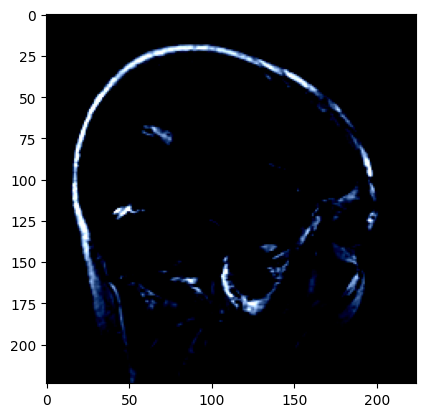

In [ ]:
# (canal, filas, columnas)
# (3, 256, 256)
# (256, 256, 3)
# Convertir de Tensor a Numpy
def tensor2numpy(tensor):
  return tensor.permute(1, 2, 0).numpy()

idx = random.randint(0,len(dataset))
plt.imshow(tensor2numpy(dataset[idx][0]))

***
<span style="font-family:Cambria Math">

XXXXXXX
</span>

***
<span style="font-family:Cambria Math">

XXXXXX
</span>

***
<span style="font-family:Cambria Math">

XXXXXX
</span>

***

<span style="font-family:Cambria Math">

# 4. Entrenamiento de los modelos

## 4.1. Modelo Básico

</span>

In [ ]:
#

***

<span style="font-family:Cambria Math">

## 4.1. Modelo AlexNet ajustado (fine-tuning)

</span>

In [ ]:
# Hiperparámetros
batch_size = 32
num_epochs = 40
learning_rate = 1e-4
umbral_epochs = 10 # (i.e. detener el entrenamiento si no hay mejora durante umbral_epochs epochs)

# Trabajar en GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# Partición de los datos
size_dataset  = len(dataset)
size_entrenmiento = int(0.6 * size_dataset)
size_validacion = int(0.2 * size_dataset)
size_test = size_dataset - size_entrenmiento - size_validacion

# Carga "lazy" de las particiones
dataset_train, dataset_val, dataset_test = random_split(
    dataset,
    [size_entrenmiento, size_validacion, size_test],
    generator=torch.Generator().manual_seed(1)
)

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(dataset_val,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(dataset_test,  batch_size=batch_size, shuffle=False)

In [ ]:
train_loader

In [ ]:
# Cargar modelo
model = models.alexnet(pretrained=True) # .cache #

# "Congelamos" únicamente los features del modelo que sirven como base para cualquier aplicación de CNNs
# Es decir, mantenemos la configuración de las capas que detectan formas básicas, bordes, esquinas, texturas, etc.
for param in model.features.parameters():
    param.requires_grad = False

# Ahora podemos hacer fine-tuning con un dataset en particular

# Observemos la arquitectura del modelo
model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# Adaptando AlexNet para nuestra aplicación
# AlexNet tiene un submodulo "classifier" que por defecto espera un número de features (capa anterior)
num_features = model.classifier[6].in_features # Por defecto es 1000
model.classifier[6] = nn.Linear(num_features, num_labels) # Modificamos la capa para un output de 4 labels
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# Cargar al device elegido
model = model.to(device)

In [ ]:
# Función de pérdida y optimizador
loss_f = nn.CrossEntropyLoss() # TODO: Probar otras función losses
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 3) Training loop with early stopping
pesos_mejor_modelo = copy.deepcopy(model.state_dict())
mejor_loss_val  = float('inf')
epochs_no_imp  = 0


TODO:
- [ ] Acumular train y val loss para plotear
- [ ] Acumular train y val accuracy para plotear



In [ ]:
for epoch in range(1, num_epochs+1):

    # Entrenamieto
    model.train() # Al parecer aplica dropout -> Entender
    loss_acumulada = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_f(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_acumulada += loss.item() * imgs.size(0)

    train_loss = loss_acumulada / len(train_loader.dataset)

    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad(): # Desactiva la actualización de parámetos (no gradient)
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = loss_f(outputs, labels)
            val_loss += loss.item() * imgs.size(0)

    val_loss /= len(val_loader.dataset)
    print(f"Epoch {epoch}/{num_epochs}  Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < mejor_loss_val:
        mejor_loss_val = val_loss
        pesos_mejor_modelo = copy.deepcopy(model.state_dict())
        epochs_sin_mejorar = 0
    else:
        epochs_sin_mejorar += 1
        if epochs_sin_mejorar >= umbral_epochs:
            print(f"→ Early stopping después de {epoch} epochs.")
            break

Epoch 1/40  Train Loss: 0.4174  Val Loss: 0.2431
Epoch 2/40  Train Loss: 0.2068  Val Loss: 0.2106
Epoch 3/40  Train Loss: 0.1514  Val Loss: 0.1725
Epoch 4/40  Train Loss: 0.1134  Val Loss: 0.1489
Epoch 5/40  Train Loss: 0.0831  Val Loss: 0.1760
Epoch 6/40  Train Loss: 0.0762  Val Loss: 0.1592
Epoch 7/40  Train Loss: 0.0768  Val Loss: 0.1335
Epoch 8/40  Train Loss: 0.0520  Val Loss: 0.1571
Epoch 9/40  Train Loss: 0.0478  Val Loss: 0.1555
Epoch 10/40  Train Loss: 0.0555  Val Loss: 0.1888
Epoch 11/40  Train Loss: 0.0398  Val Loss: 0.1278
Epoch 12/40  Train Loss: 0.0331  Val Loss: 0.1429
Epoch 13/40  Train Loss: 0.0297  Val Loss: 0.1679
Epoch 14/40  Train Loss: 0.0200  Val Loss: 0.1799
Epoch 15/40  Train Loss: 0.0250  Val Loss: 0.2004
Epoch 16/40  Train Loss: 0.0444  Val Loss: 0.1765
Epoch 17/40  Train Loss: 0.0263  Val Loss: 0.1569
Epoch 18/40  Train Loss: 0.0234  Val Loss: 0.2190
Epoch 19/40  Train Loss: 0.0157  Val Loss: 0.1926
Epoch 20/40  Train Loss: 0.0277  Val Loss: 0.1739
Epoch 21/

In [ ]:
# pesos_mejor_modelo

In [ ]:
# Cargar mejores pesos
model.load_state_dict(pesos_mejor_modelo)

# Test
model.eval()
correctos = 0
total   = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, predicciones = torch.max(outputs, 1)
        correctos += (predicciones == labels).sum().item()
        total += labels.size(0)

test_accuracy = correctos / total * 100 # PROBAR TAMBIÉN F-SCORE
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 95.45%


***
<span style="font-family:Cambria Math">

# 6. Análisis de resultados y conclusiones

XXXXXX
</span>

In [ ]:
# def visualization_history(resultsFit):
#     """
#     Esta función grafica las curvas de precisión a lo largo de las épocas de entrenamiento
#     para el conjunto de prueba como el de validación.
#     Parámetros:
#     resultsFit = historial de entrenamiento de un modelo entensorflow.keras
#     Salida:
#     Gráfica de la precisión en validación y prueba.
#     """
#     # Llamado al entrono de la gráfica y fijar tamaño de visualización
#     fig, axes = plt.subplots(1, 2, figsize=(13, 5))

#     # Graficar la presición de la historia en entrenamiento
#     axes[0].plot(range(len(resultsFit.history['accuracy'])), resultsFit.history['accuracy'],
#            '#5a2ff4', linestyle = "-", marker = "o",
#            label='Precisión entrenamiento', lw = 3)

#     # Graficar la presición de la historia en validación
#     axes[0].plot(range(len(resultsFit.history['val_accuracy'])), resultsFit.history['val_accuracy'],  '#60d13e',
#            label='Precisión validación', linestyle = '-', marker = 'o', lw = 3)

#     # Umbral 90% de precisión
#     axes[0].plot(range(len(resultsFit.history['val_accuracy'])), 0.9*np.ones(len(resultsFit.history['val_accuracy'])),
#                'red', lw = 3, label = 'Umbral')

#     # Títulos de los ejes
#     axes[0].set_xlabel('Época',fontsize=16)
#     axes[0].set_ylabel(r'Precisión',fontsize=16)
#     axes[0].set_ylim(top=1) # Límite de la grafica
#     axes[0].grid()      # Activar la cuadricula
#     axes[0].legend(fontsize=14,loc = 'lower right')   # Establecer la legenda


#     # Graficar la pérdida de la historia en entrenamiento
#     axes[1].plot(range(len(resultsFit.history['loss'])), resultsFit.history['loss'],
#            '#5a2ff4', linestyle = "-", marker = "o",
#            label='Pérdida entrenamiento', lw = 3)

#     # Graficar la presición de la historia en validación
#     axes[1].plot(range(len(resultsFit.history['val_loss'])), resultsFit.history['val_loss'],  '#60d13e',
#            label='Pérdida validación', linestyle = '-', marker = 'o', lw = 3)

#     # Títulos de los ejes
#     axes[1].set_xlabel('Época',fontsize=16)
#     axes[1].set_ylabel(r'Pérdida',fontsize=16)
#     axes[1].grid()      # Activar la cuadricula
#     axes[1].legend(fontsize=14,loc = 'upper right')   # Establecer la legenda


#     plt.tight_layout() # Ajusta automáticamente el diseño de la figura
#     plt.show()

In [ ]:
# # Evaluación del modelo en el conjunto de prueba
# results = model.evaluate(X_test, y_test_onehot)

# # Los resultados contendrán los valores de las métricas definidas, por ejemplo, pérdida y precisión.
# print(f'Pérdida en el conjunto de prueba: {results[0]:0.2f}')
# print(f'Precisión en el conjunto de prueba:{results[1]:0.2f}')

***
<span style="font-family:Cambria Math">

XXXXXXX
</span>

***
<span style="font-family:Cambria Math">

# 7. Referencias
</span>

***
<span style="font-family:Cambria Math">

[¹] **Pytorch, entranando un clasificador**  
Disponible en: [Pytorch.org](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)



</span>





